# Setup

Show the versions of all the software that is installed into the virutalenv.

In [1]:
%matplotlib inline

In [2]:
import os
import pandas
import numpy as np
from numpy import deg2rad
from matplotlib.pyplot import rcParams
from gaitanalysis import gait, controlid, motek
from dtk import process

In [3]:
import sys
sys.path.append('../src')
import utils

In [4]:
PATHS = utils.config_paths()

# Load Data Set #1

Obinna provided me with some normal walking data. We exported the data from the D-Flow Motion Capture Module and included the HMB outputs. D-Flow sets missing values from HBM data to `0.000000` in the CSV file so I replace them with `NA` when loading. I also set the resulting data frame's index to the `TimeStamp` column. 

In [5]:
obinna = pandas.read_csv(os.path.join(PATHS['raw_data_dir'], 'T001', 'mocap-001.txt'),
                         delimiter='\t', index_col="TimeStamp", na_values='0.000000')
obinna.interpolate(method='index', inplace=True)

The data frame has quite a few time series which are all floats except for the `FrameNumber` column which is an integer.

In [6]:
obinna

FrameNumber  LHEAD.PosX  LHEAD.PosY  LHEAD.PosZ  THEAD.PosX  \
TimeStamp                                                                 
534.133513         1505   -0.132270    1.801454   -0.109339   -0.033648   
534.143432         1506   -0.133878    1.802301   -0.110094   -0.035053   
534.153492         1507   -0.135803    1.803772   -0.112392   -0.036993   
534.163440         1508   -0.137673    1.804514   -0.111986   -0.038249   
534.173667         1509   -0.139050    1.805609   -0.112472   -0.040130   
534.183657         1510   -0.139708    1.806518   -0.112732   -0.042013   
534.193694         1511   -0.141454    1.807322   -0.112297   -0.042503   
534.203663         1512   -0.142636    1.808365   -0.113005   -0.044488   
534.213693         1513   -0.143685    1.809031   -0.113113   -0.045947   
534.223640         1514   -0.143985    1.809994   -0.113110   -0.046508   
534.233744         1515   -0.144588    1.811345   -0.113157   -0.046900   
534.243690         1516   -0.145197    1.811921   -0.112521   -0.048058   
534.253640         1517   -0.145517    1.812781   -0.112328   -0.048858   
534.263661         1518   -0.145848    1.813747   -0.112466   -0.049118   
534.273497         1519   -0.143298    1.814136   -0.113542   -0.049237   
534.283495         1520   -0.143277    1.814736   -0.112973   -0.049289   
534.293643         1521   -0.143238    1.815121   -0.112337   -0.049020   
534.303642         1522   -0.142581    1.815544   -0.112299   -0.048954   
534.313709         1523   -0.142515    1.815684   -0.111864   -0.048337   
534.323697         1524   -0.142215    1.815694   -0.110875   -0.047747   
534.333423         1525   -0.141278    1.816072   -0.110652   -0.047259   
534.343719         1526   -0.140918    1.816006   -0.110396   -0.046574   
534.353681         1527   -0.139926    1.815831   -0.109601   -0.045448   
534.363493         1528   -0.139096    1.816058   -0.109017   -0.044800   
534.373649         1529   -0.138265    1.815972   -0.108664   -0.044239   
534.383530         1530   -0.137640    1.815984   -0.108724   -0.043590   
534.393686         1531   -0.136145    1.815438   -0.108581   -0.042212   
534.403480         1532   -0.135189    1.815102   -0.107230   -0.041250   
534.413413         1533   -0.134256    1.814230   -0.106162   -0.040538   
534.423518         1534   -0.133807    1.813996   -0.105780   -0.039747   
...                 ...         ...         ...         ...         ...   
589.422392         7034   -0.110434    1.812354   -0.189596   -0.016302   
589.432394         7035   -0.111860    1.813508   -0.189268   -0.017174   
589.442406         7036   -0.112725    1.814326   -0.189260   -0.018626   
589.452389         7037   -0.113964    1.815681   -0.188951   -0.019876   
589.462386         7038   -0.114789    1.817424   -0.189346   -0.021066   
589.472410         7039   -0.116014    1.818156   -0.189532   -0.022269   
589.482401         7040   -0.116818    1.819201   -0.189215   -0.023223   
589.492367         7041   -0.117887    1.820205   -0.189482   -0.023975   
589.502350         7042   -0.118487    1.821558   -0.189068   -0.025096   
589.512359         7043   -0.119351    1.821862   -0.189261   -0.026175   
589.522299         7044   -0.120080    1.822899   -0.188888   -0.026986   
589.532387         7045   -0.120606    1.824318   -0.189311   -0.027115   
589.542390         7046   -0.120962    1.825099   -0.189862   -0.028191   
589.552448         7047   -0.121881    1.826217   -0.189706   -0.028472   
589.562408         7048   -0.122375    1.826946   -0.189425   -0.028817   
589.572394         7049   -0.122455    1.827309   -0.189343   -0.029146   
589.582305         7050   -0.122641    1.827561   -0.188961   -0.029615   
589.592443         7051   -0.123032    1.827980   -0.189219   -0.029805   
589.602331         7052   -0.122736    1.828317   -0.189066   -0.030102   
589.612296         7053   -0.123120    1.828645   -0.188663   -0.030392   
589.622388         7054   -0.123389  

For this analysis we are only interested in the vertical ground reaction forces, the joint angles, the joint angular rates, and the joint torques. The D-Flow HBM computations give the angles and the torques. We will compute the rates ourselves. Here is a list of all of the vertical GRF, joint angle, and joint moment data.

In [7]:
[col for col in obinna.columns if col.endswith('.Ang') or col.endswith('ForY') or col.endswith('.Mom')]

['FP1.ForY',
 'FP2.ForY',
 'PelvisX.Ang',
 'PelvisX.Mom',
 'PelvisY.Ang',
 'PelvisY.Mom',
 'PelvisZ.Ang',
 'PelvisZ.Mom',
 'PelvisYaw.Ang',
 'PelvisYaw.Mom',
 'PelvisForwardPitch.Ang',
 'PelvisForwardPitch.Mom',
 'PelvisRightRoll.Ang',
 'PelvisRightRoll.Mom',
 'TrunkFlexion.Ang',
 'TrunkFlexion.Mom',
 'TrunkRightBend.Ang',
 'TrunkRightBend.Mom',
 'TrunkLeftTwist.Ang',
 'TrunkLeftTwist.Mom',
 'HeadFlexion.Ang',
 'HeadFlexion.Mom',
 'HeadRightBend.Ang',
 'HeadRightBend.Mom',
 'HeadLeftTwist.Ang',
 'HeadLeftTwist.Mom',
 'RShoulderUp.Ang',
 'RShoulderUp.Mom',
 'LShoulderUp.Ang',
 'LShoulderUp.Mom',
 'RShoulderForward.Ang',
 'RShoulderForward.Mom',
 'LShoulderForward.Ang',
 'LShoulderForward.Mom',
 'RShoulderInward.Ang',
 'RShoulderInward.Mom',
 'LShoulderInward.Ang',
 'LShoulderInward.Mom',
 'RShoulderFlexion.Ang',
 'RShoulderFlexion.Mom',
 'LShoulderFlexion.Ang',
 'LShoulderFlexion.Mom',
 'RShoulderAbduction.Ang',
 'RShoulderAbduction.Mom',
 'LShoulderAbduction.Ang',
 'LShoulderAbduction.

The angles are in degrees, so lets convert them to radians.

In [8]:
for col in obinna.columns:
    if col.endswith('.Ang'):
        obinna[col] = deg2rad(obinna[col])

The vertical ground reaction forces are stored as variables with the extension `.ForY` and the right and left plates are designated by `FP2` and `FP1` respectively. The following plot shows the right foot vertical ground reaction force in Newtons.

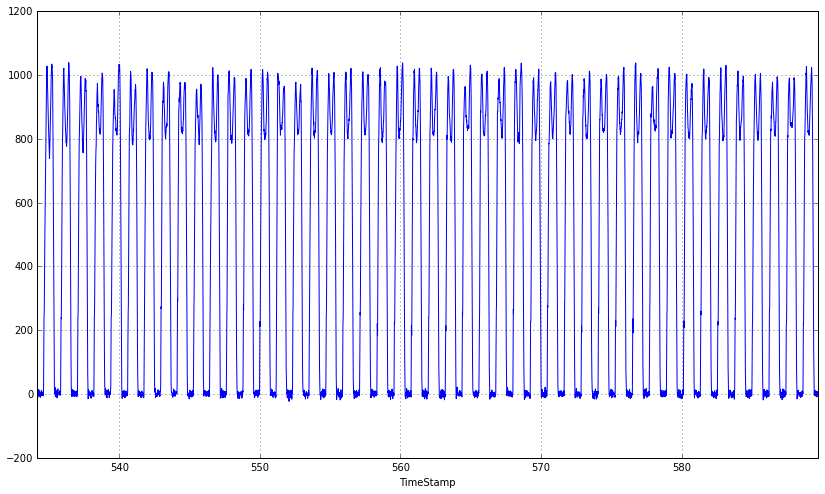

In [9]:
rcParams['figure.figsize'] = 14, 8
obinna['FP2.ForY'].plot()

# Process Data Set #1

We will first use the ground reaction forces to find the heel strike and toe off times during gait. I'll select a portion of the data which has suitable GRF profiles for extracting the landmarks.

In [10]:
start = 500
stop = 3500

data = gait.GaitData(obinna.iloc[start:stop].copy())

Now I compute all of the joint angular rates numerically with central differencing.

In [11]:
to_diff = [col for col in obinna.columns if col.endswith('.Ang')]
new_names = [name.split('.')[0] + '.Rate' for name in to_diff]

data.time_derivative(to_diff, new_names)

data.data[new_names]

PelvisX.Rate  PelvisY.Rate  PelvisZ.Rate  PelvisYaw.Rate  \
TimeStamp                                                              
539.133881      0.150772      0.004067      0.102778        0.552121   
539.143890      0.160928      0.009767      0.093144        0.505838   
539.153929      0.170549      0.014374      0.082798        0.459838   
539.163913      0.178955      0.017302      0.070936        0.408815   
539.173887      0.190744      0.019407      0.059362        0.358745   
539.183359      0.197429      0.019709      0.045226        0.296807   
539.193338      0.198429      0.018185      0.029573        0.233192   
539.203378      0.199925      0.015748      0.014679        0.181954   
539.213772      0.206671      0.013416      0.000550        0.142576   
539.223469      0.207478      0.011444     -0.013507        0.100413   
539.233942      0.206354      0.011305     -0.026519        0.058741   
539.243898      0.213412      0.014016     -0.039252        0.022641   
539.253891      0.213183      0.017157     -0.050315       -0.002819   
539.263928      0.209303      0.018911     -0.062615       -0.007630   
539.273928      0.207934      0.020806     -0.077989        0.005244   
539.283377      0.199457      0.023791     -0.090748        0.033425   
539.293321      0.183137      0.026638     -0.100232        0.086142   
539.303321      0.168660      0.030369     -0.112451        0.164448   
539.313352      0.152336      0.036833     -0.124700        0.241379   
539.323356      0.134465      0.046203     -0.135236        0.306354   
539.333433      0.114397      0.055829     -0.141228        0.365114   
539.343934      0.098550      0.068395     -0.149885        0.430953   
539.353936      0.087635      0.086624     -0.164598        0.505088   
539.363435      0.073404      0.101984     -0.170530        0.544087   
539.373326      0.056608      0.109381     -0.163898        0.537701   
539.383922      0.044262      0.121110     -0.163228        0.541004   
539.393907      0.034274      0.142311     -0.169458        0.552473   
539.403358      0.021718      0.157747     -0.161861        0.512470   
539.413350      0.007556      0.168445     -0.146465        0.455156   
539.423367     -0.008350      0.178241     -0.129488        0.406799   
...                  ...           ...           ...             ...   
568.832779     -0.086854     -0.216061      0.077546        0.542278   
568.842797     -0.057147     -0.202581      0.081217        0.491240   
568.852847     -0.027617     -0.189945      0.086070        0.478310   
568.862824     -0.000403     -0.176650      0.092154        0.496089   
568.872822      0.023261     -0.157173      0.095547        0.520262   
568.883406      0.045001     -0.142434      0.101418        0.577879   
568.893358      0.064903     -0.127624      0.108629        0.648591   
568.903396      0.077401     -0.101122      0.110309        0.668172   
568.913425      0.086243     -0.070274      0.110917        0.663626   
568.923387      0.094264     -0.041604      0.110712        0.655510   
568.933373      0.101709     -0.018906      0.109085        0.648840   
568.943435      0.109579     -0.002356      0.106672        0.645169   
568.953377      0.121395      0.009703      0.106006        0.652846   
568.962733      0.125105      0.017380      0.096593        0.602658   
568.973370      0.129305      0.022133      0.086620        0.543867   
568.983426      0.147453      0.027834      0.084086        0.525102   
568.992716      0.155454      0.030386      0.074099        0.453212   
569.002781      0.152762      0.028810      0.058842        0.349101   
569.013369      0.165951      0.027787      0.048483        0.284082   
569.022793      0.180845      0.025165      0.036241        0.222214   
569.032747      0.178974      0.020398      0.020120        0.145029   
569.043376      0.192263      0.018808      0.005571        0.083415   
569.052749      0.205879      0.018241     -0.010108

The strikes and toe offs can then be computed for this data.

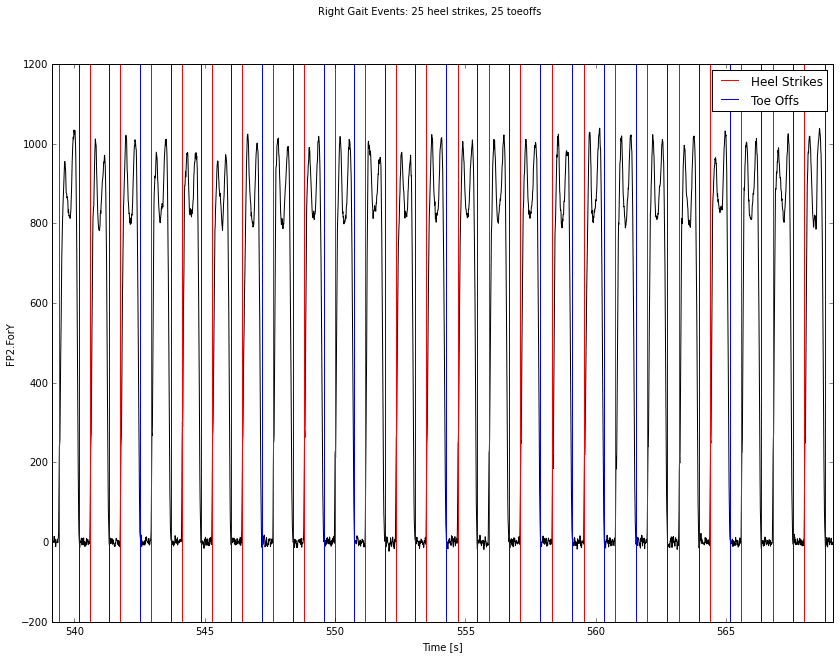

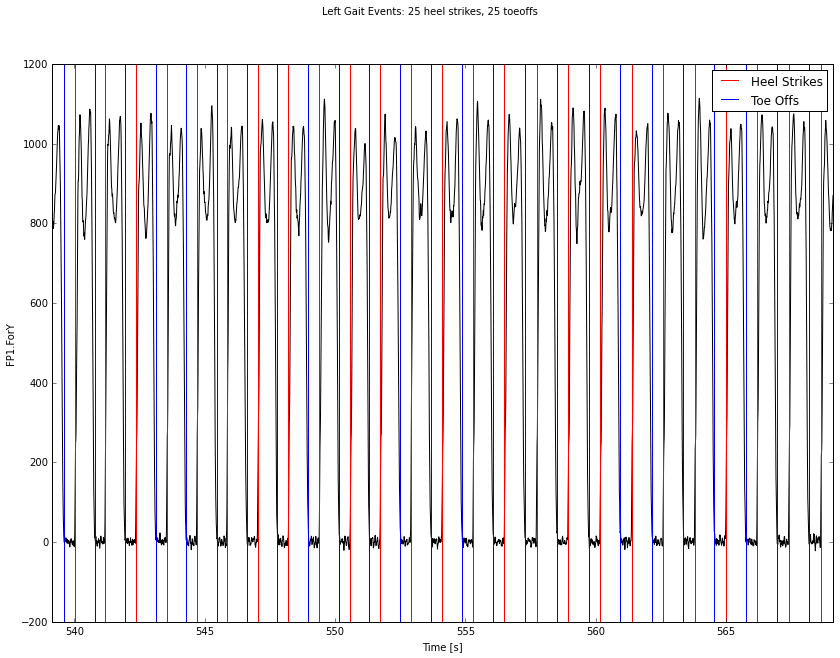

In [12]:
rcParams['figure.figsize'] = 14, 10
right_strikes, left_strikes, right_offs, left_offs = \
    data.grf_landmarks('FP2.ForY', 'FP1.ForY', do_plot=True, threshold=28.0)

Now we can section the gait cycle based on the right foot and interpolate at 10 distinct equally spaced points in the gait cycle.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7c85ef0850>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f7c85d592d0>], dtype=object)

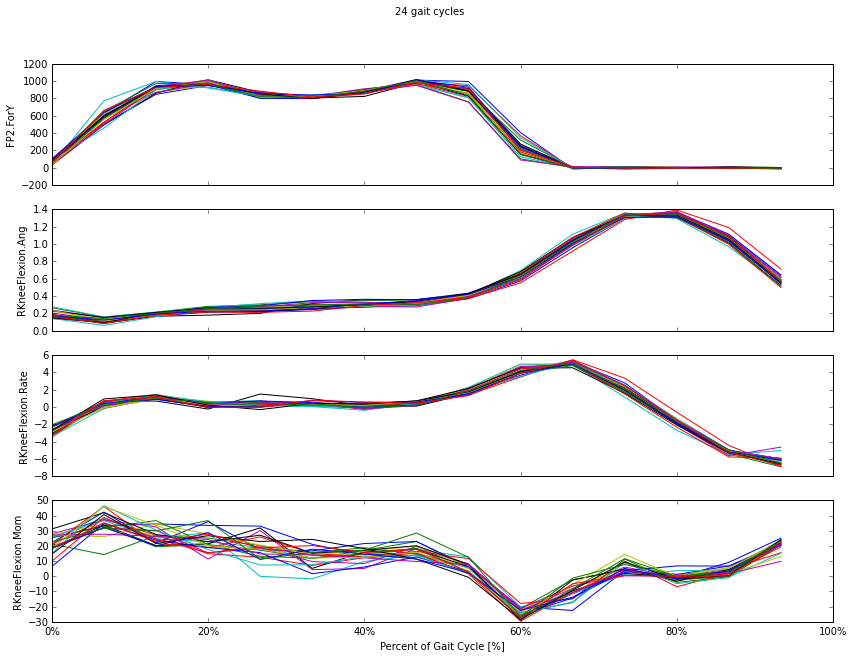

In [13]:
rcParams['figure.figsize'] = 14, 10
right_steps = data.split_at('right', num_samples=15)
data.plot_gait_cycles('FP2.ForY', 'RKneeFlexion.Ang', 'RKneeFlexion.Rate',
                      'RKneeFlexion.Mom', marker='o')

We can see the mean gait cycle easily:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7c85f79590>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f7c8588db10>], dtype=object)

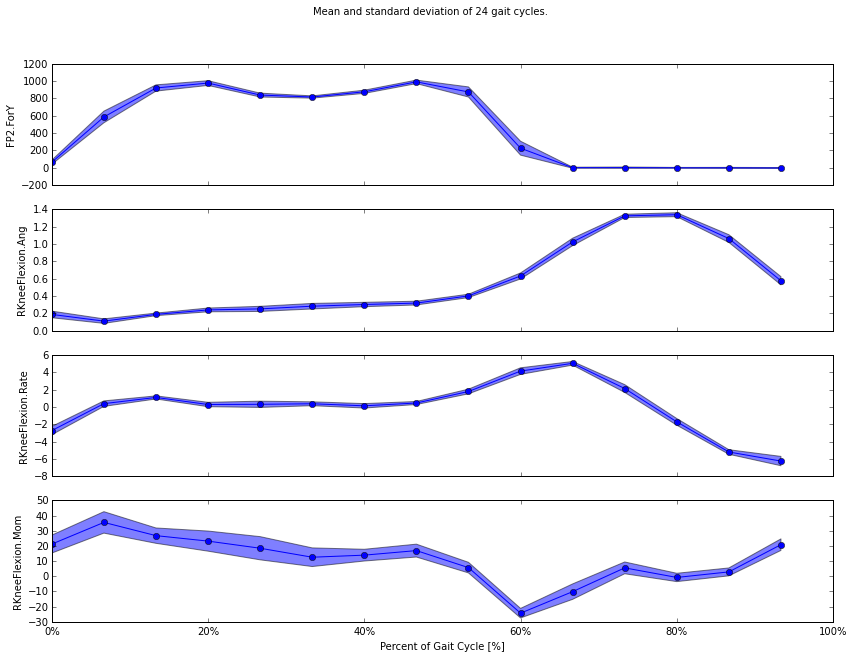

In [14]:
data.plot_gait_cycles('FP2.ForY', 'RKneeFlexion.Ang', 'RKneeFlexion.Rate', 'RKneeFlexion.Mom', mean=True)

# Identify Controller with Full Gain Matrix for Data Set #1

At this point we have the data in the form needed to identify a simple linear controller where we assume the sensors are fed back and subtract from a set point in the walking gait cycle, to give the error in the gait. This error vector is then multiplied by a gain matrix and added to the limit cycle control torques to power the plant in walking.

The following gives the equation that generates the controls given the error in the sensors at a single time step during a single foot step. $t$ here represents the time in the gait cycle, not time across all steps.

$$m_m(t) = m(t)_0 + K(t) s_e(t) = m(t)_0 + K(t) [s_0(t) - s_m(t)]$$

Now rearrange the equations such that we have one linear in both the gains, $K(t)$, and in $m^*(t)$:

$$m_m(t) = m(t)_0 + K(t) s_0(t) - K(t) s_m(t) = m^*(t) - K(t) s_m(t)$$

Here I specify the hypothesized sensors and controls, and the data to initialized the solver:

In [15]:
sensors = ['RKneeFlexion.Ang',
           'RKneeFlexion.Rate',
           'RHipFlexion.Ang',
           'RHipFlexion.Rate',
           'LKneeFlexion.Ang',
           'LKneeFlexion.Rate',
           'LHipFlexion.Ang',
           'LHipFlexion.Rate']

controls = ['RKneeFlexion.Mom',
            'RHipFlexion.Mom',
            'LKneeFlexion.Mom',
            'LHipFlexion.Mom']

solver = controlid.SimpleControlSolver(right_steps, sensors, controls)

Now we can solve the linear system for the gains at each time step and the $m^*(t)$:

In [16]:
gains, controls_star, variance, gain_var, controls_star_var, estimated_controls = solver.solve()

In [17]:
gains.shape

(15, 4, 8)

The following plot shows the identified gains as a function of the percentage of the gait cycle. The rows correspond to the controller outputs and the columns to the measured sensors. The shaded region depicts the standard deviation in the estimates.

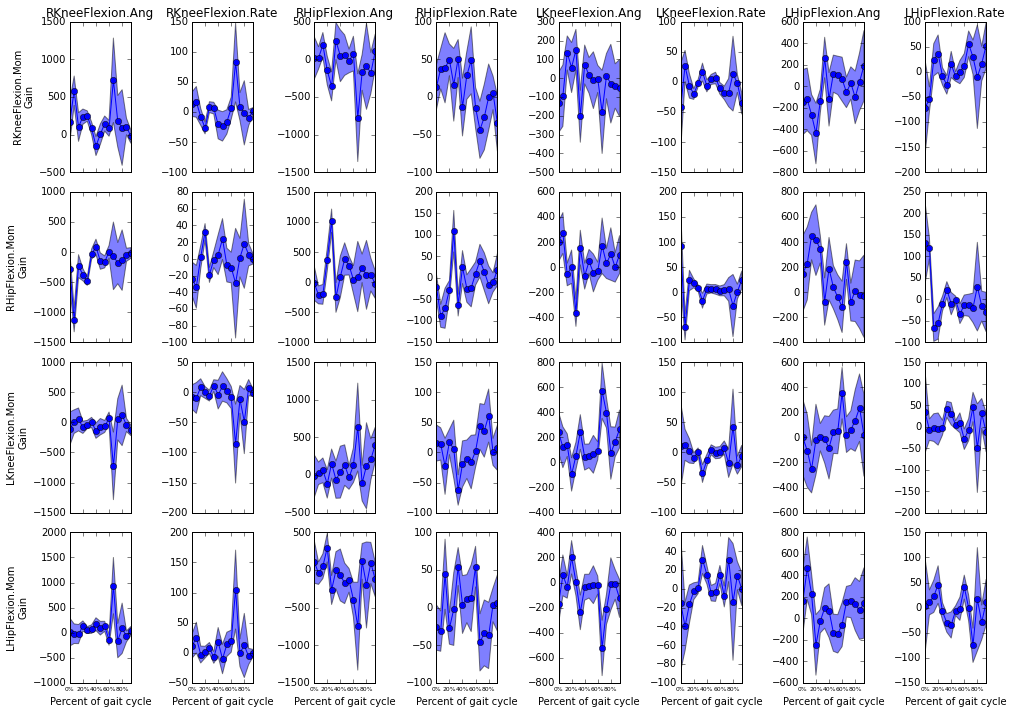

In [18]:
axes = solver.plot_gains(gains, gain_var)

The variance in the fit is:

In [19]:
variance

array([ 20.18781651])

And the following plot shows the measured controls at each point in the gain cycle (blue line) and the controller generated controls given the measured sensors (green dots). The error bars on the green dots show the variance in the fit.

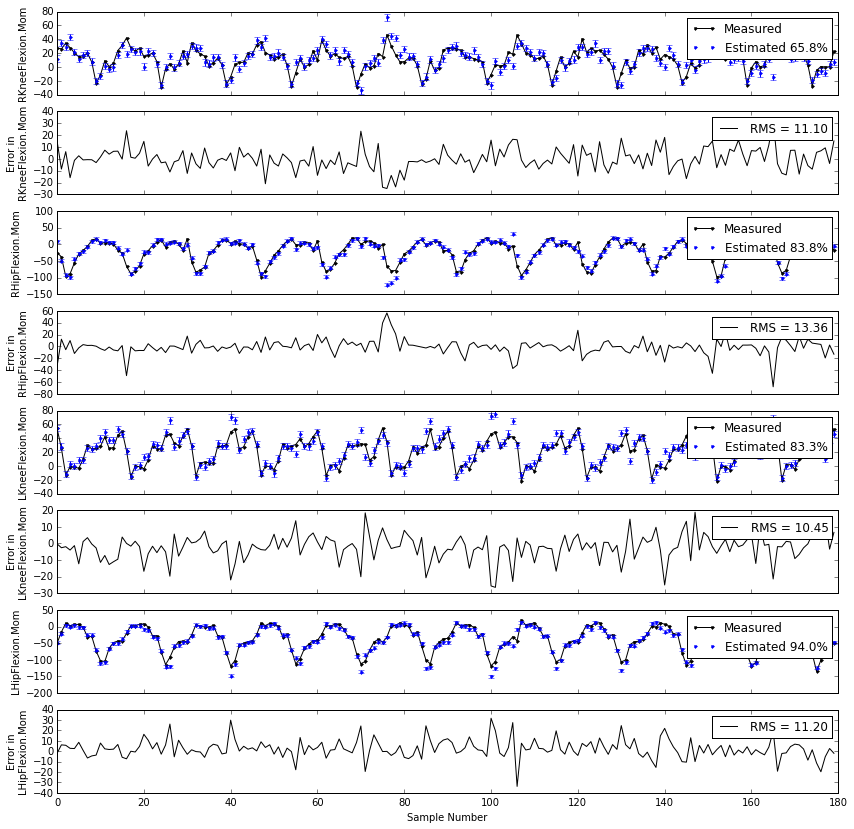

In [20]:
rcParams['figure.figsize'] = 14, 14
axes = solver.plot_estimated_vs_measure_controls(estimated_controls, variance)

To get an idea of how each of the controller inputs affects the outputs I plot the contribution from each sensor error and gain to the different controls. To do this I make the assumption that the commanded angles and rates of the joints are the mean over a set of steps.

$$s_0(t) = \bar{s}(t)$$

Then I can solve for $m_0(t)$:

$$m_0(t) = m(t) - K(t) [\bar{s}(t) - s(t)]$$

And the contribution of $K(t) [\bar{s}(t) - s(t)]$ to each of the controls $m(t)$ can be computed:

$$m_1(t) = m_{0_1}(t) + K_{11} s_{e_1} + \ldots + + K_{1p} s_{e_p}$$

I plot the contributions from each sensor error and the nominal moments as stacked bar charts to get an idea of the contributions at each step. The first four steps are shown.

The line plots below the bar charts show the same contributions but as a mean with respect to the step. Notice that the mean of the controller contributions is zero. This seems odd to me and believe it is an artifact of assuming the nominal sensors to be the mean of the sensors over the steps.

I was expecting to see patterns in the controller behavior across the steps but if the majority of the control moments are due to $m_0(t)$ then the controller is just responsible for applying any moments due to deviations from $m_0(t)$.

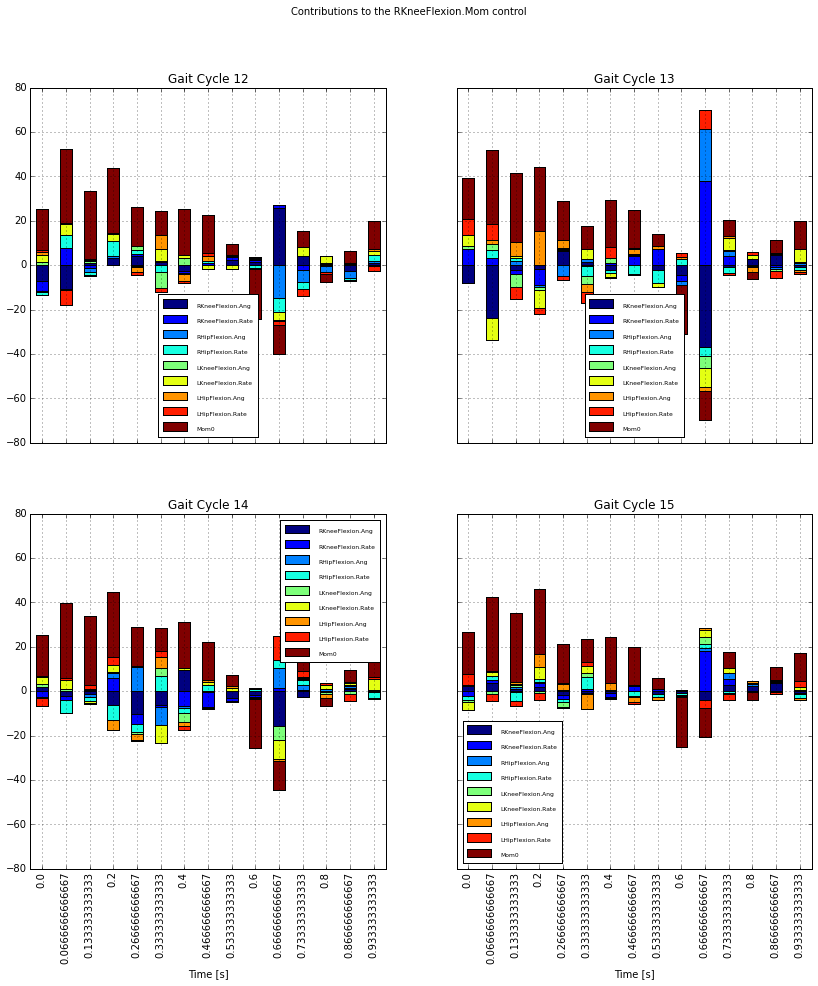

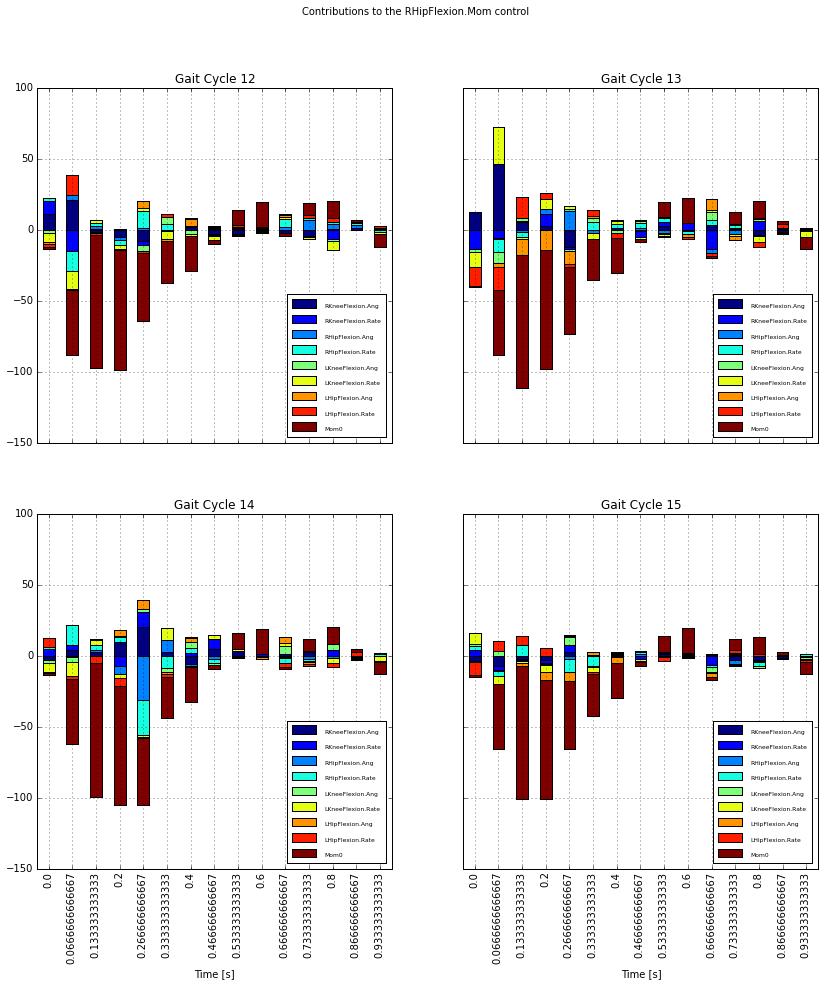

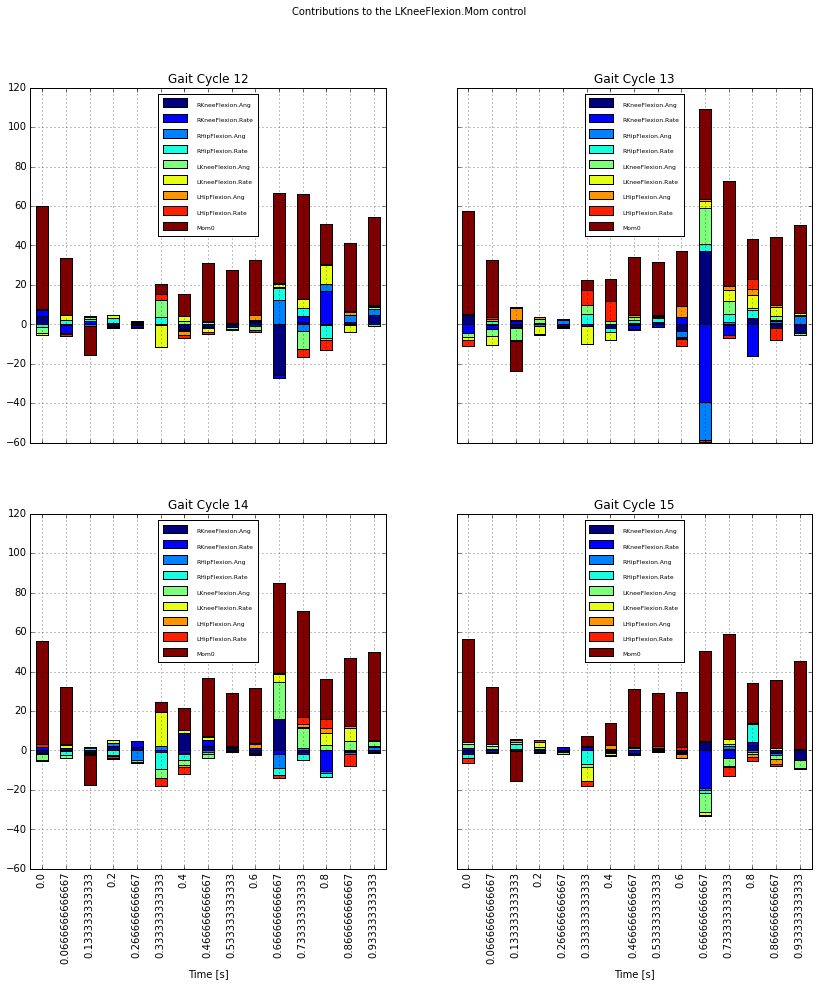

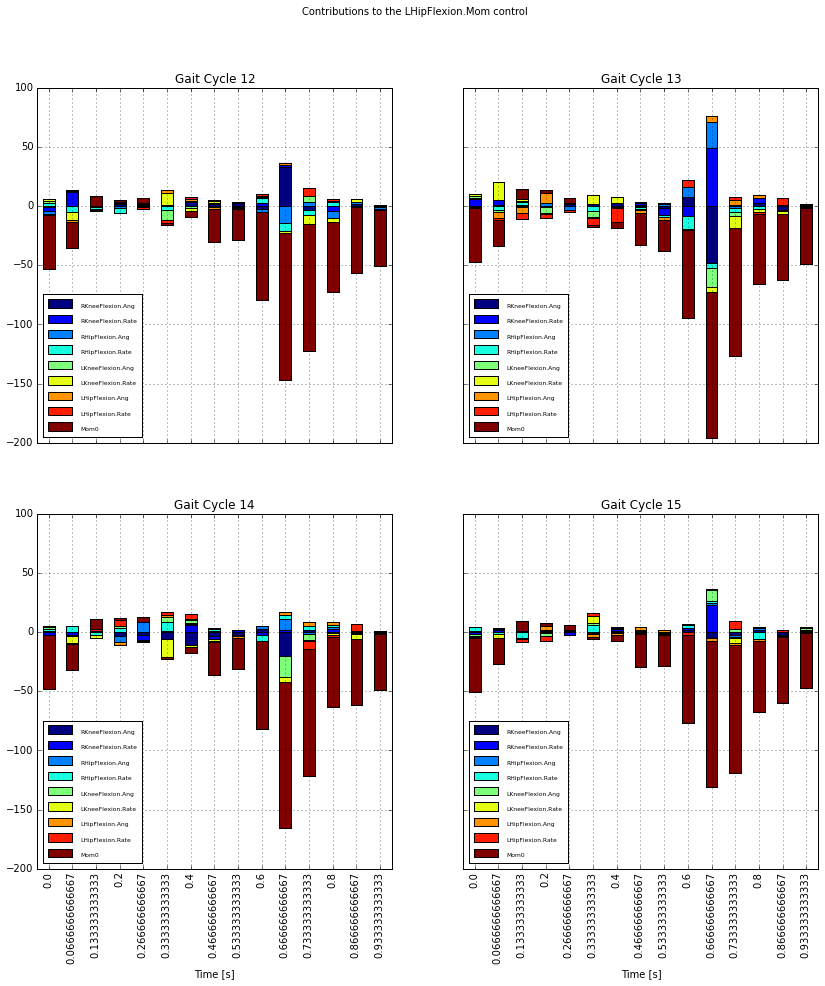

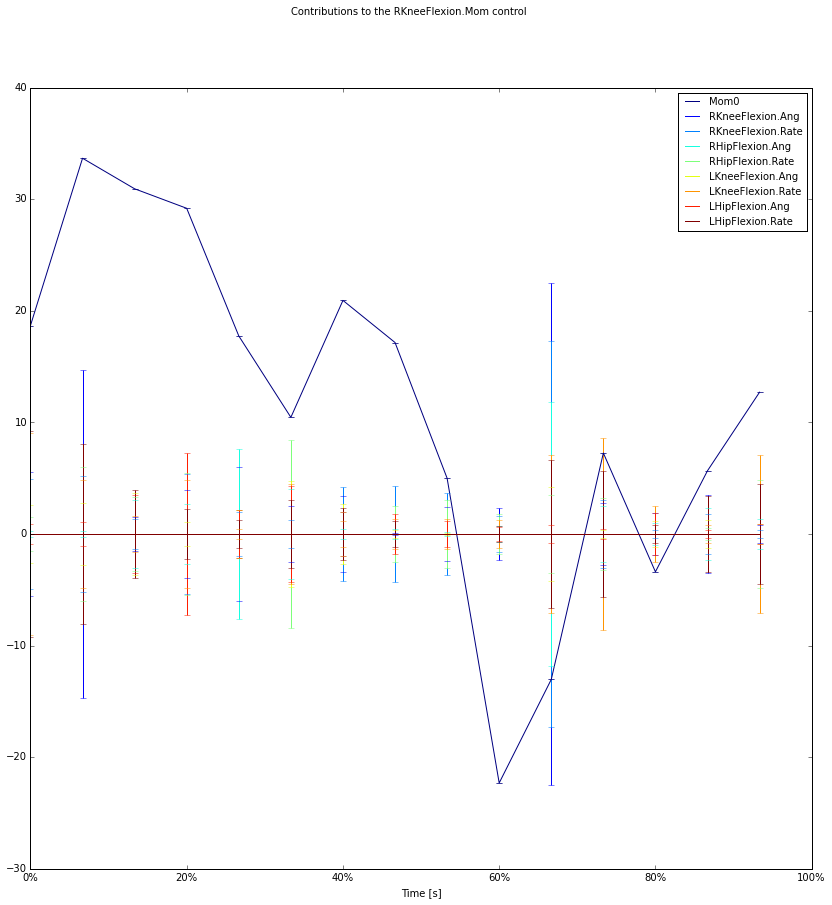

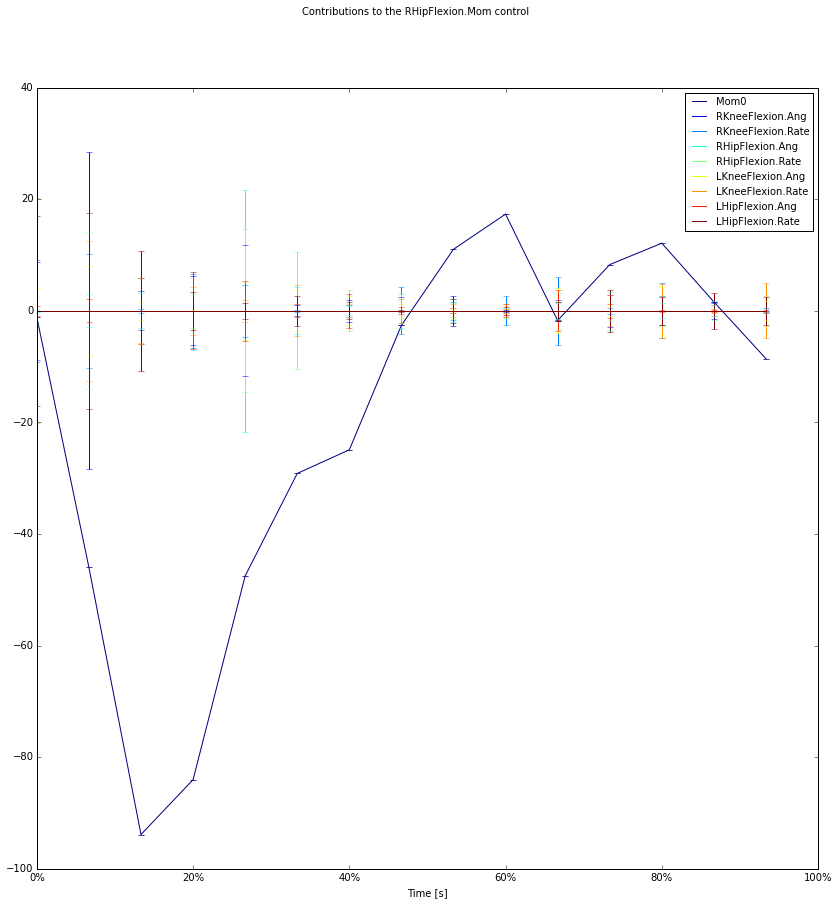

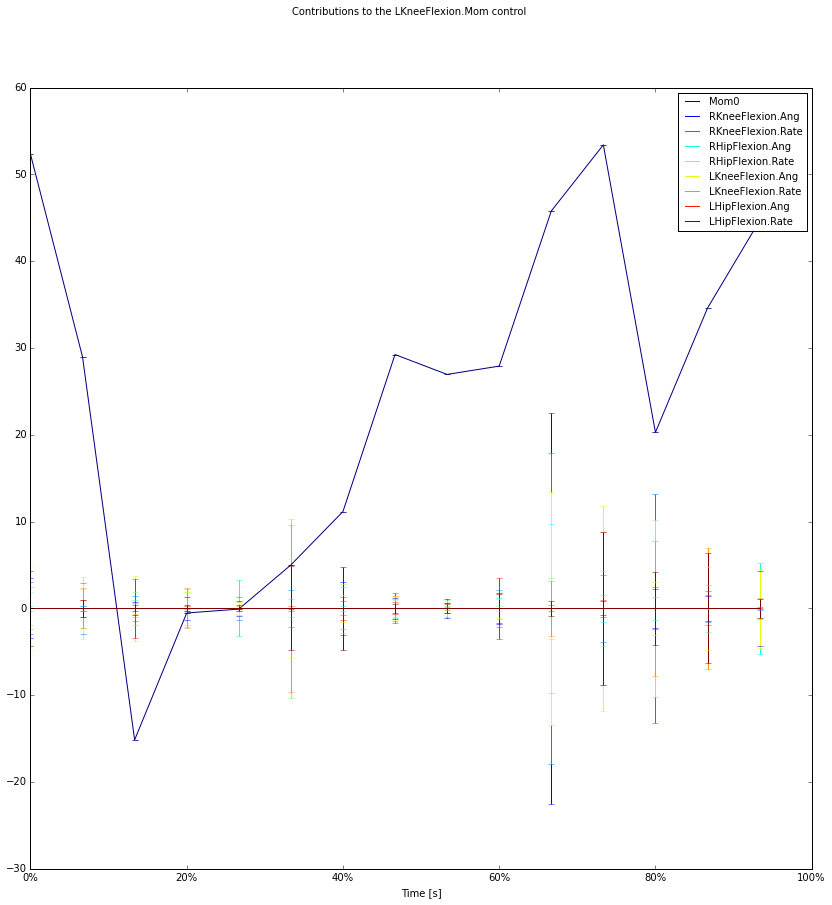

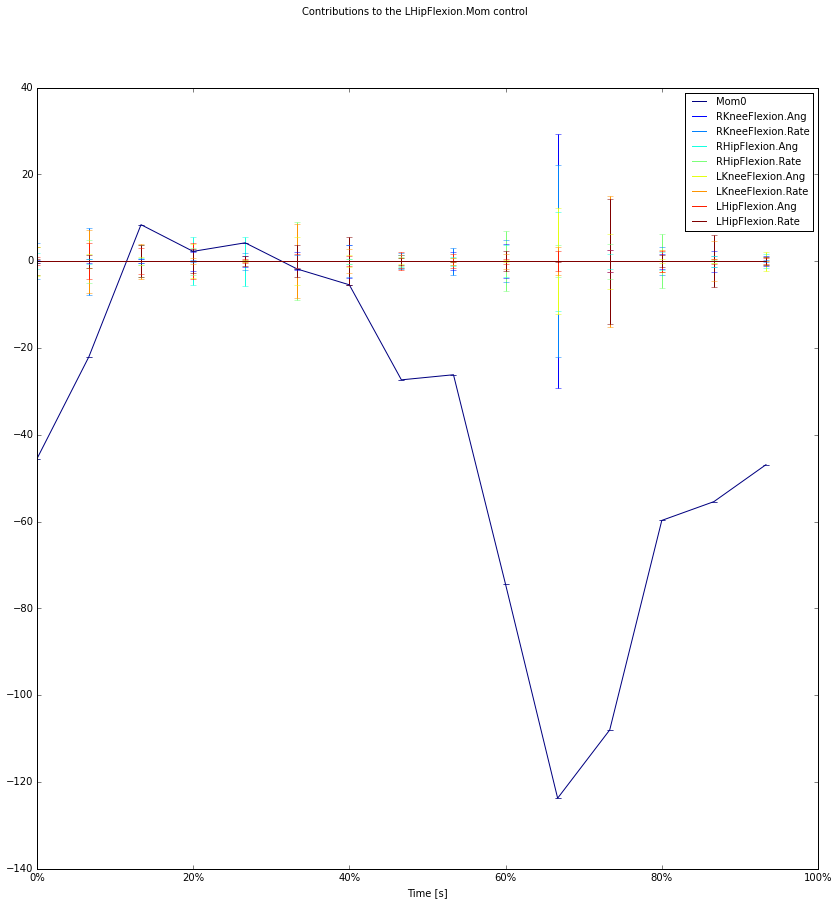

In [21]:
solver.plot_control_contributions(estimated_controls)

# Identify Controller with "Diagonal" Gain Matrix for Data Set #1

In [22]:
gain_inclusion_matrix = np.ones((len(controls), len(sensors))).astype(bool)
gain_inclusion_matrix[2:, :4] = False
gain_inclusion_matrix[:2, 4:] = False
gain_inclusion_matrix

array([[ True,  True,  True,  True, False, False, False, False],
       [ True,  True,  True,  True, False, False, False, False],
       [False, False, False, False,  True,  True,  True,  True],
       [False, False, False, False,  True,  True,  True,  True]], dtype=bool)

In [23]:
gains, controls_star, variance, gain_var, controls_star_var, estimated_controls = \
    solver.solve(gain_inclusion_matrix=gain_inclusion_matrix)

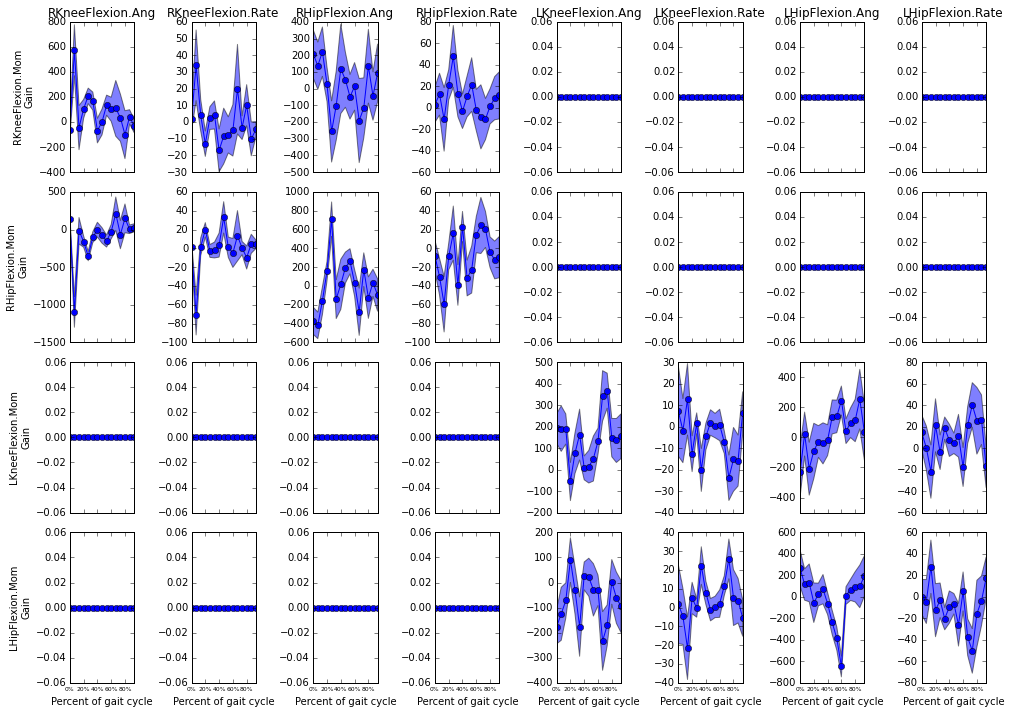

In [24]:
rcParams['figure.figsize'] = 14, 10
axes = solver.plot_gains(gains, gain_var)

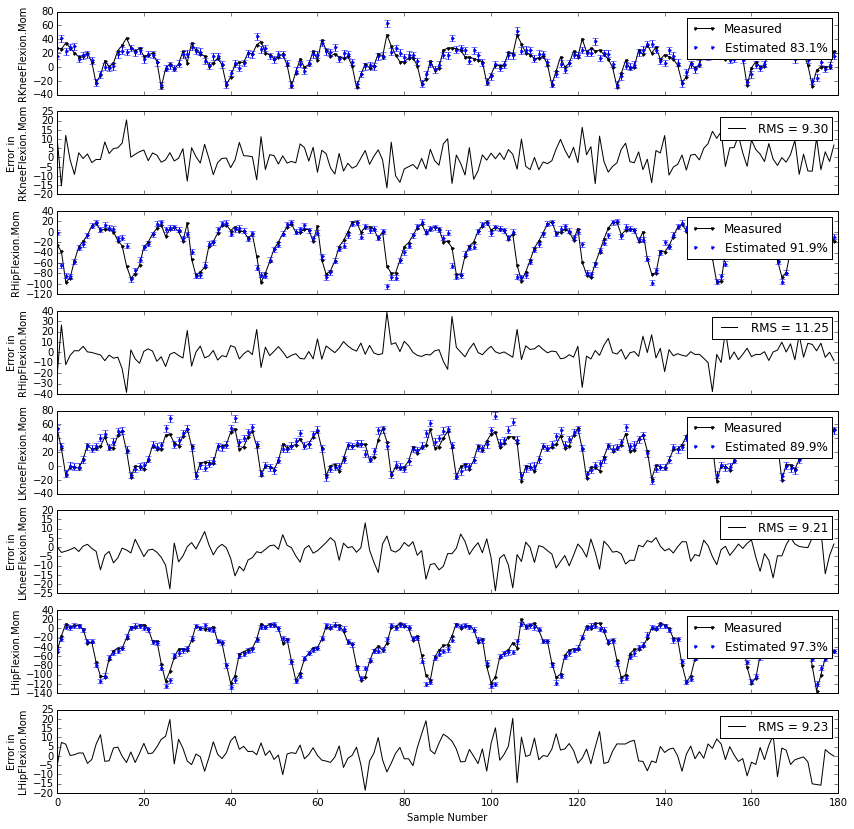

In [25]:
rcParams['figure.figsize'] = 14, 14
axes = solver.plot_estimated_vs_measure_controls(estimated_controls, variance)

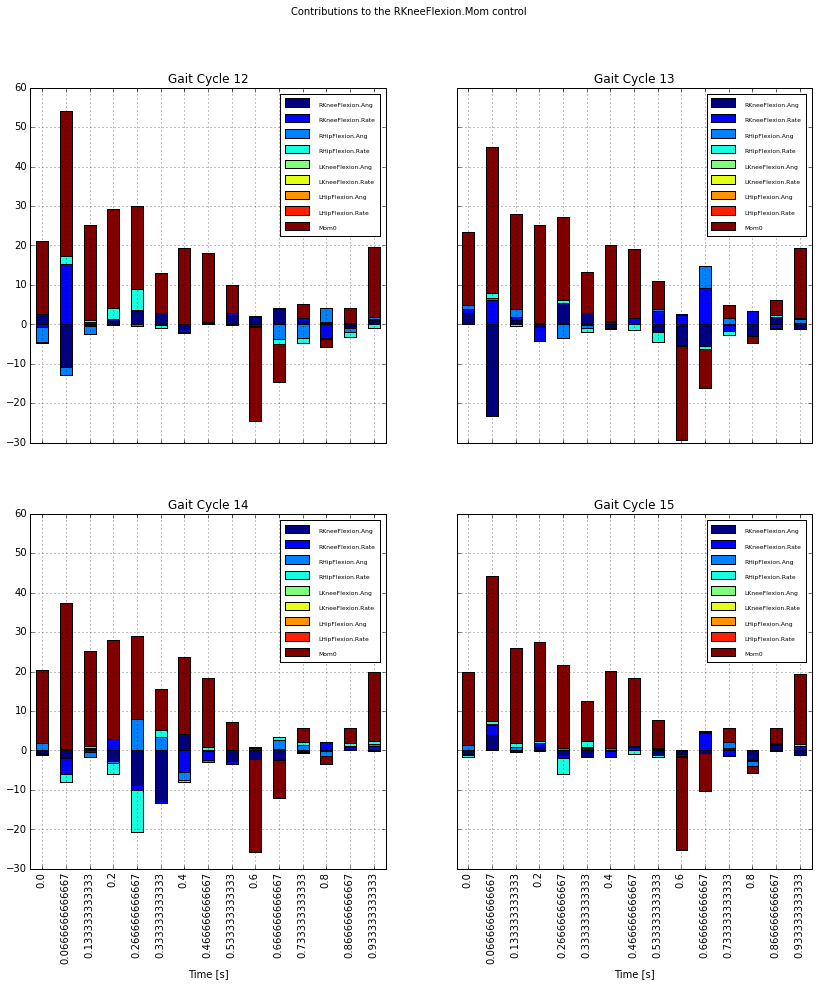

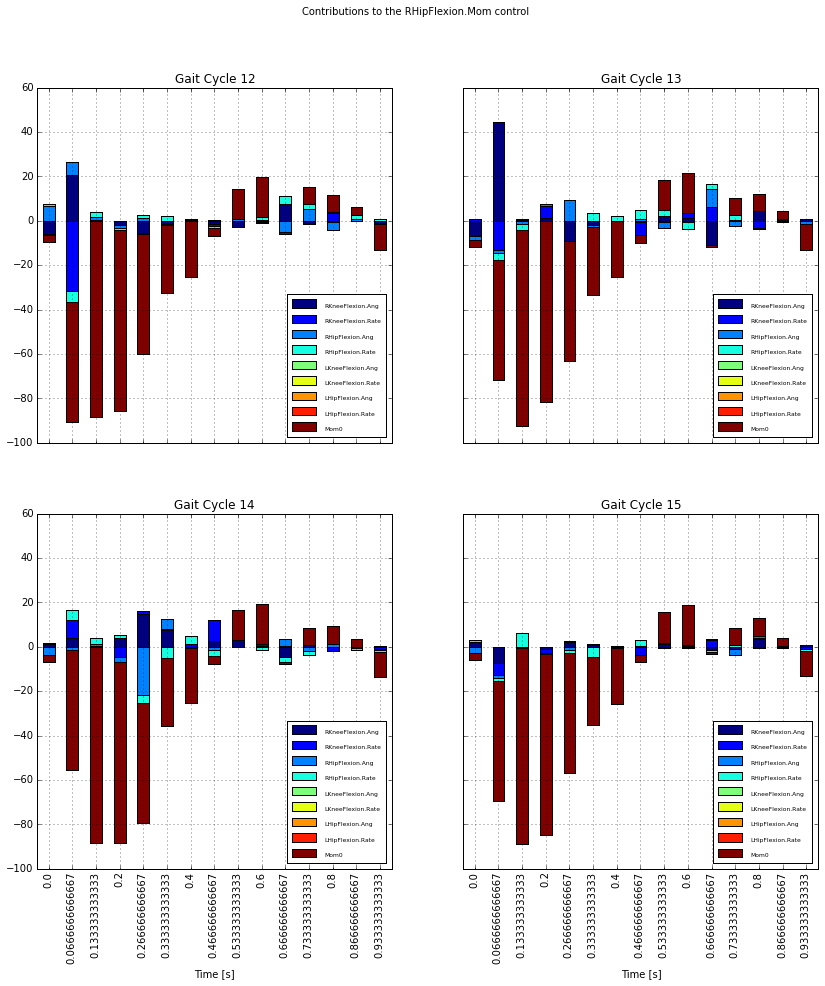

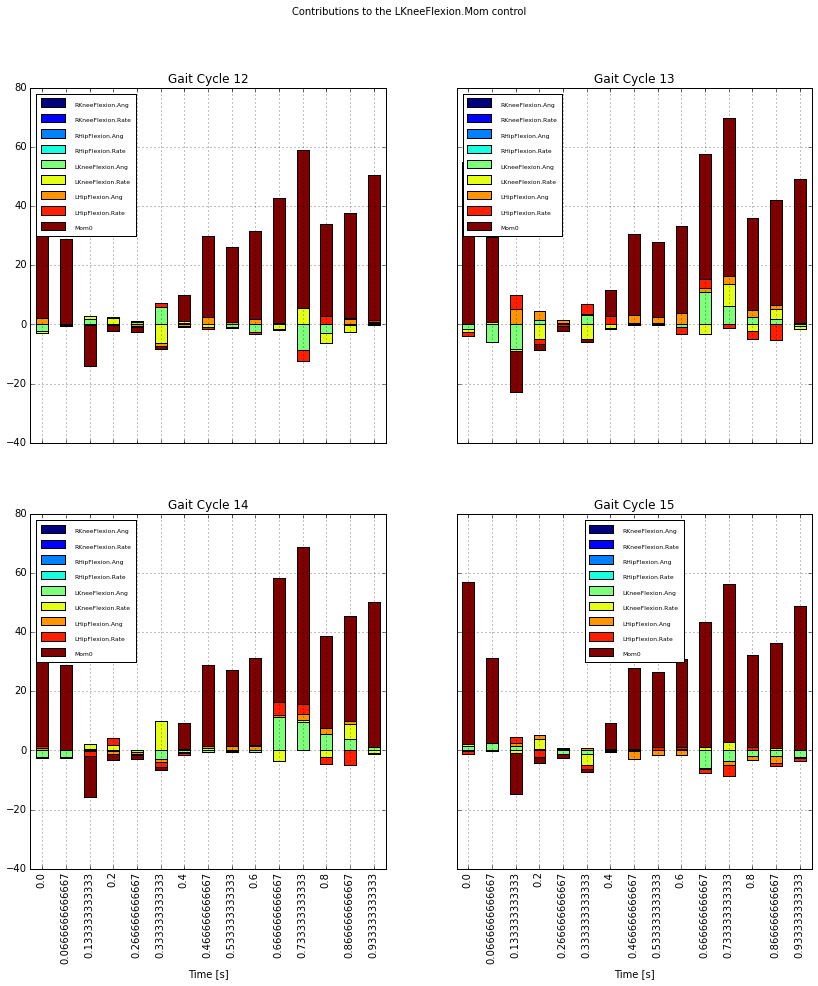

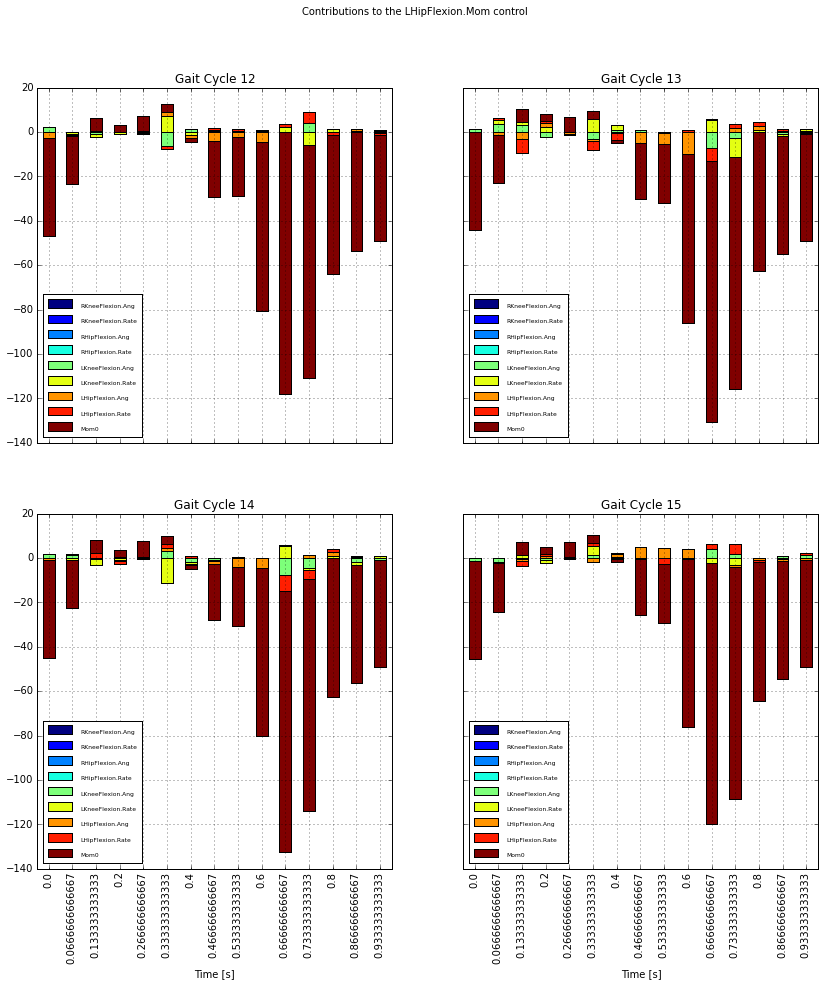

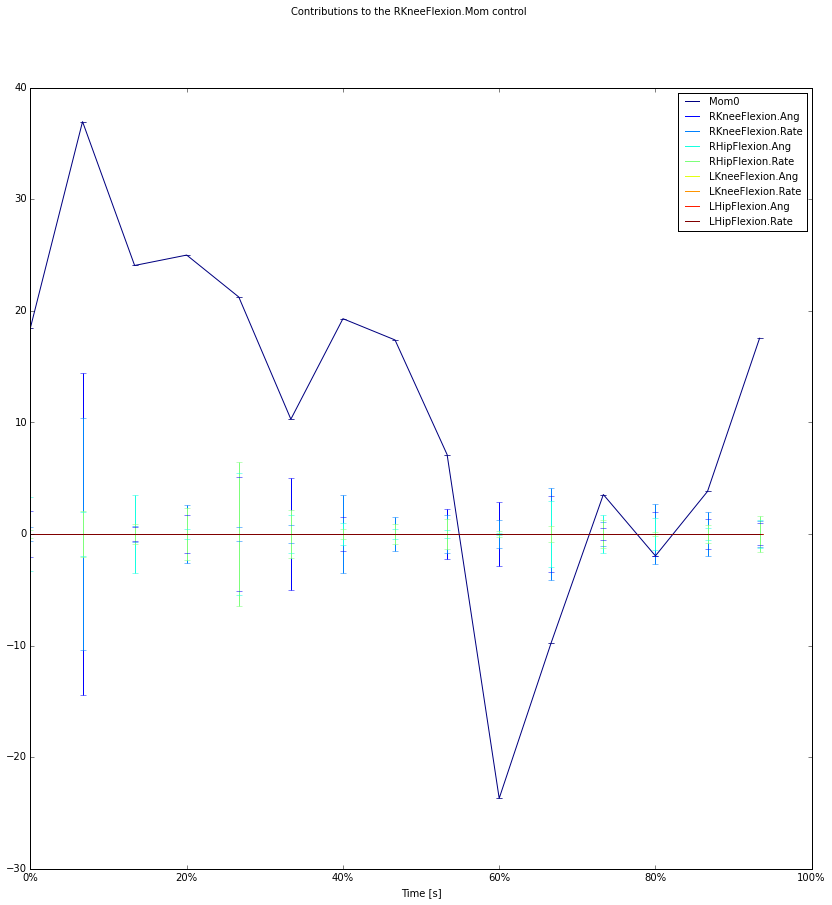

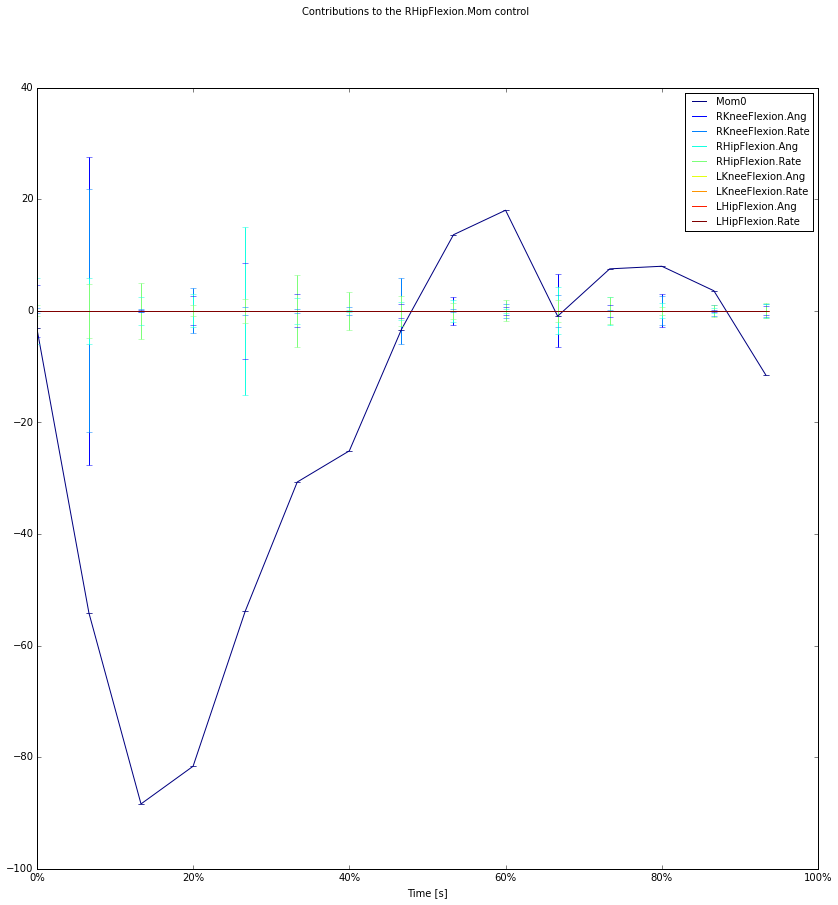

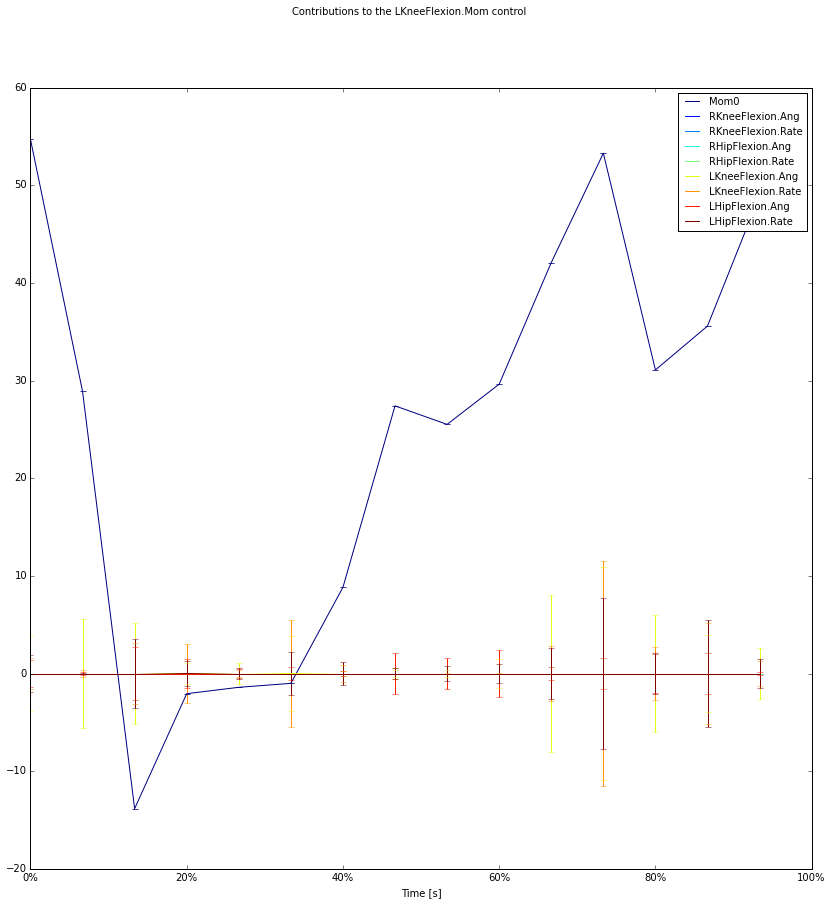

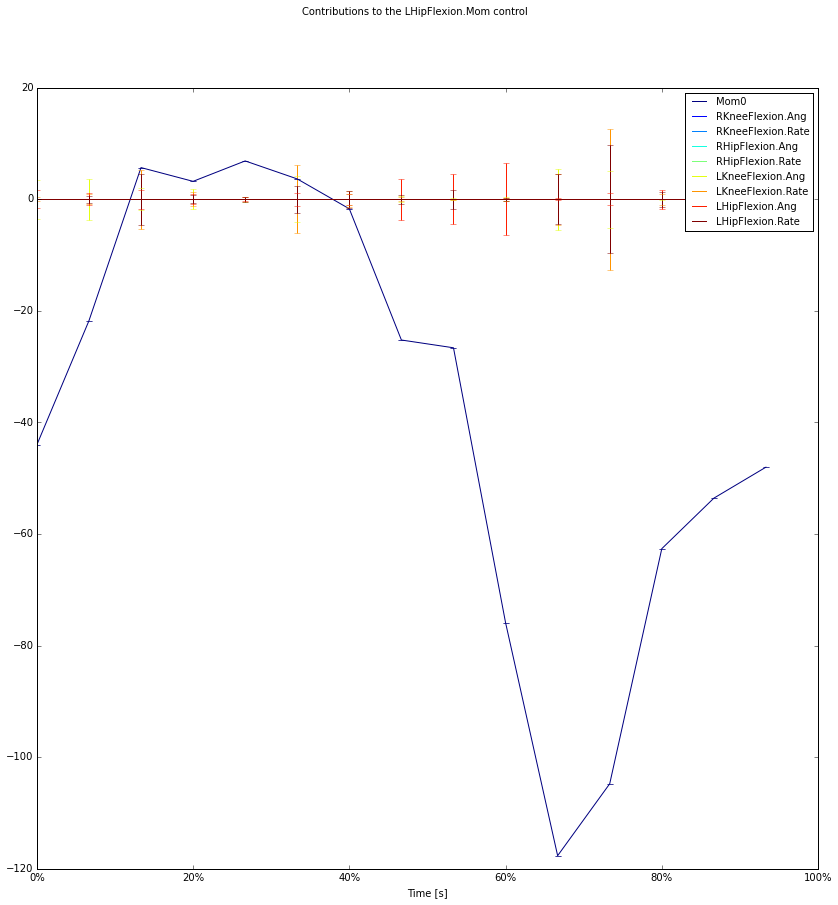

In [26]:
rcParams['figure.figsize'] = 14, 14
solver.plot_control_contributions(estimated_controls)

# Simplest Control: Each Control Only Senses From Its Joint

In [27]:
gain_inclusion_matrix = np.zeros((len(controls), len(sensors))).astype(bool)
gain_inclusion_matrix[0, :2] = True
gain_inclusion_matrix[1, 2:4] = True
gain_inclusion_matrix[2, 4:6] = True
gain_inclusion_matrix[3, 6:8] = True
gain_inclusion_matrix

array([[ True,  True, False, False, False, False, False, False],
       [False, False,  True,  True, False, False, False, False],
       [False, False, False, False,  True,  True, False, False],
       [False, False, False, False, False, False,  True,  True]], dtype=bool)

In [28]:
gains, controls_star, variance, gain_var, controls_star_var, estimated_controls = \
    solver.solve(gain_inclusion_matrix=gain_inclusion_matrix)

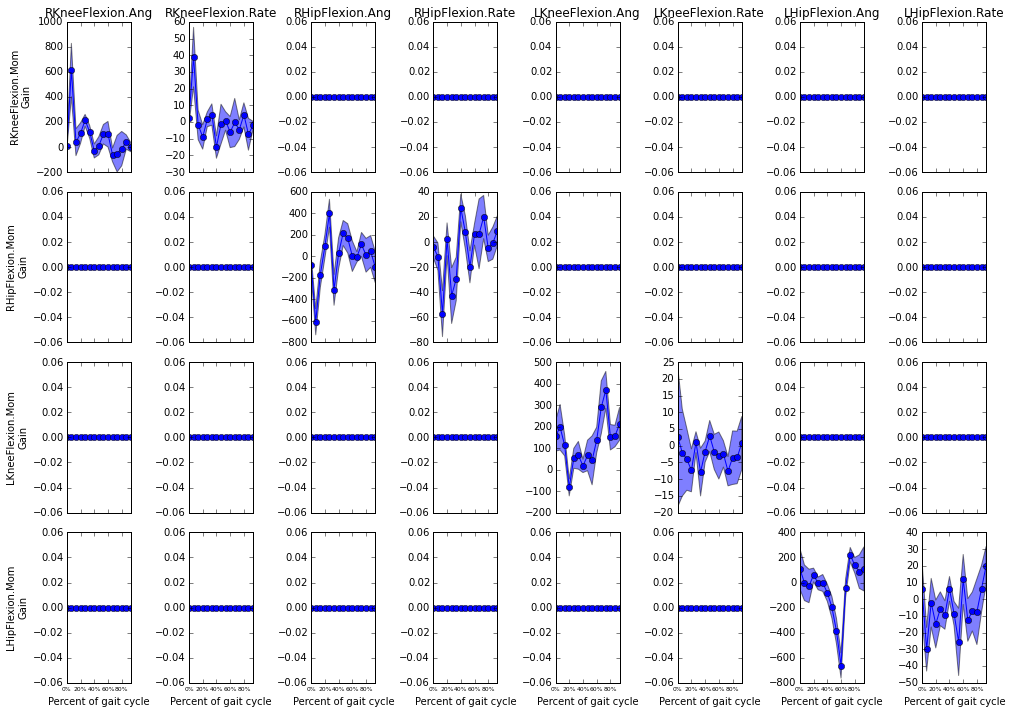

In [29]:
rcParams['figure.figsize'] = 14, 10
axes = solver.plot_gains(gains, gain_var)

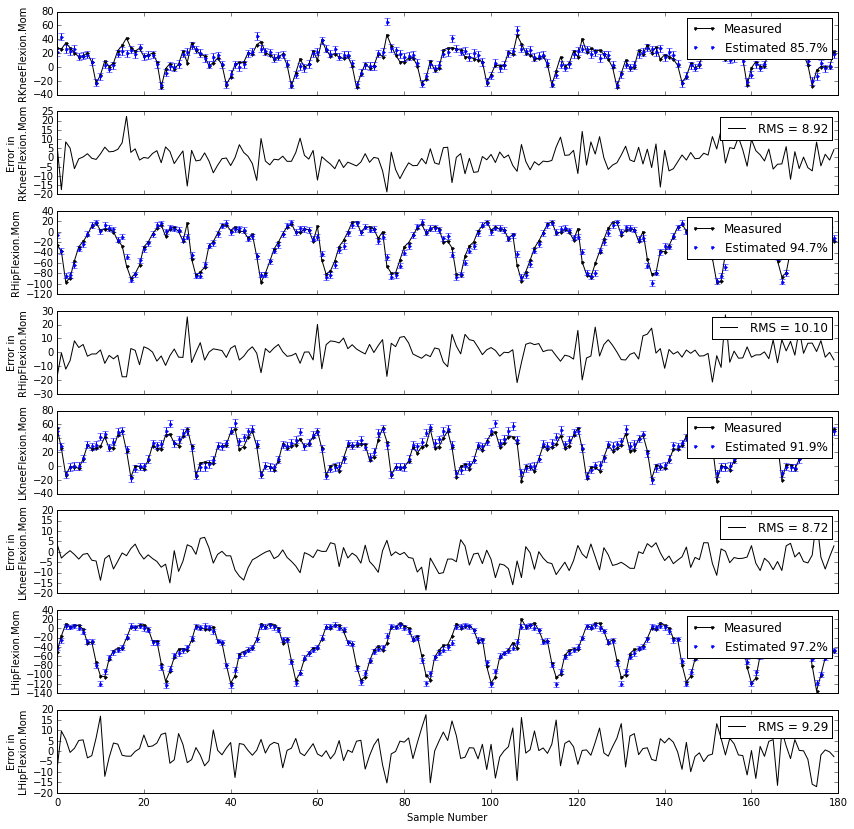

In [30]:
rcParams['figure.figsize'] = 14, 14
axes = solver.plot_estimated_vs_measure_controls(estimated_controls, variance)

# Load and Process Data Set #2

Ton also gave me some data he collected for subject doing normal walking. Here is explanation:

>Here is some data that was collected for a paper which is about to be published.  Proofs and supplementary documentation are >attached.
>
>This is from a 77 kg male, 30 seconds of walking preceded by 1 second of standing.  The treadmill speed increases gradually >in the beginning, at t=6.0 it is at its final constant speed to best to ignore anything that happens before that time.
>
>The dof file contains the generalized coordinates, dofvel the generalized velocities.  The jointmoment file the corresponding >generalized forces.  First line has the names of the generalized coordinates.  The grf file has the ground reaction forces, >which you would use to determine where you are in the gait cycle (from heelstrike to heelstrike).
>
>CAREN_Trial04.txt is the raw data (mocap and force plate).  You could actually load that file in D-Flow to produce the >variables that are on the other files, if you wanted to.

I'll do the same analysis I did for the previous data but limit everything to the right leg because the left leg force plate measurements are botched.

In [31]:
tdir = os.path.join(PATHS['raw_data_dir'], 'T002')

In [32]:
coordinates = pandas.read_csv(os.path.join(tdir, 'CAREN_Trial04_dof.txt'), delimiter='\t', index_col="TimeStamp")
speeds = pandas.read_csv(os.path.join(tdir, 'CAREN_Trial04_dofvel.txt'), delimiter='\t', index_col="TimeStamp")
generalized_forces = pandas.read_csv(os.path.join(tdir, 'CAREN_Trial04_jointmoment.txt'), delimiter='\t', index_col="TimeStamp")
ground_reaction_forces = pandas.read_csv(os.path.join(tdir, 'CAREN_Trial04_grf.txt'), delimiter='\t', index_col="TimeStamp")
raw_data = pandas.read_csv(os.path.join(tdir, 'CAREN_Trial04.txt'), delimiter='\t', index_col="TimeStamp")

Load in the separate data files and rename the columns to reflate the type of data so they can be merged into one big data frame.

In [33]:
coordinates.columns = [name + '.Ang' for name in coordinates.columns]
speeds.columns = [name + '.Rate' for name in speeds.columns]
generalized_forces.columns = [name + '.Mom' for name in generalized_forces.columns]

In [34]:
all_data = coordinates.join(speeds).join(generalized_forces).join(ground_reaction_forces)

Take the data after 15 seconds to avoid the error in the right force plate data.

In [35]:
data = gait.GaitData(all_data[all_data.index > 15.0])

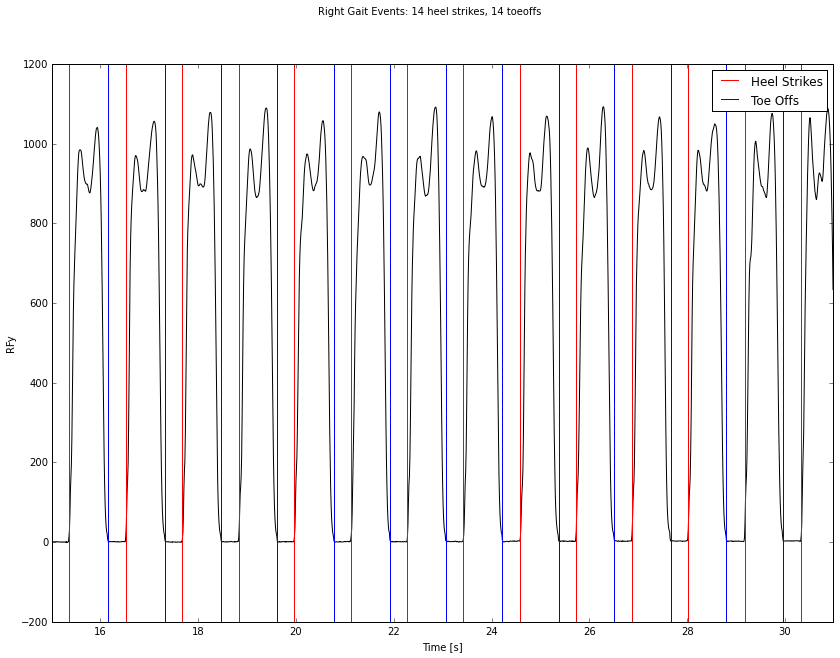

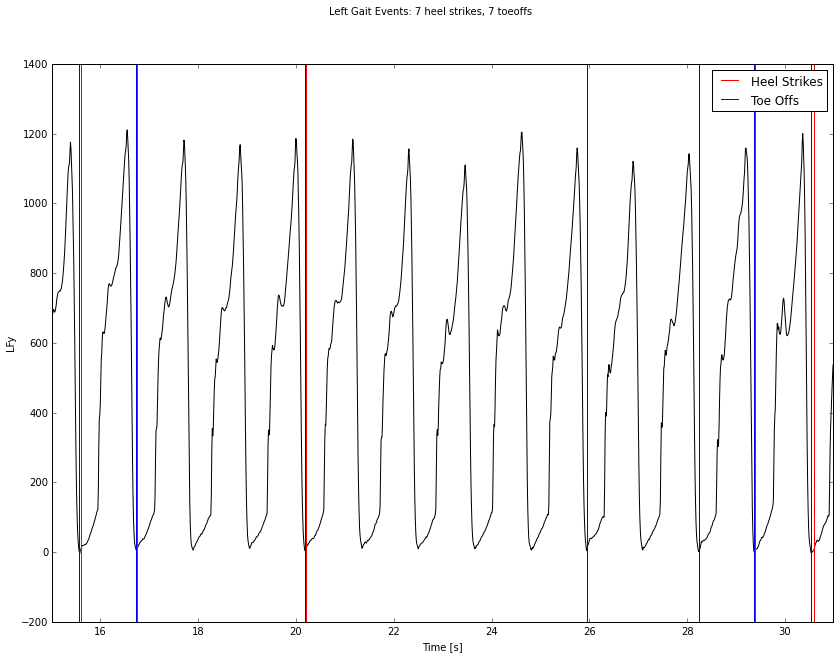

In [36]:
rcParams['figure.figsize'] = 14, 10
right_strikes, left_strikes, right_offs, left_offs = \
    data.grf_landmarks('RFy','LFy', do_plot=True, threshold=5.0)

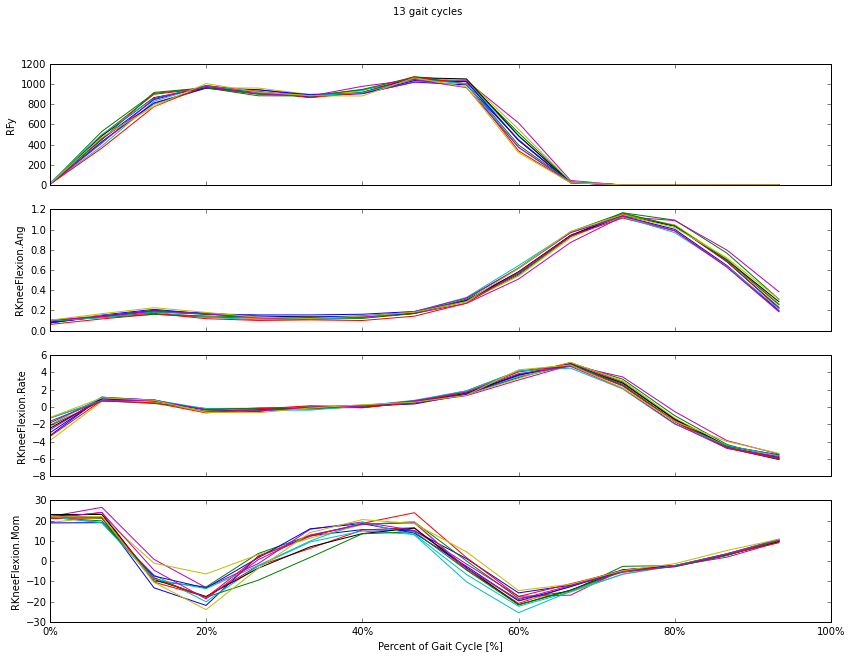

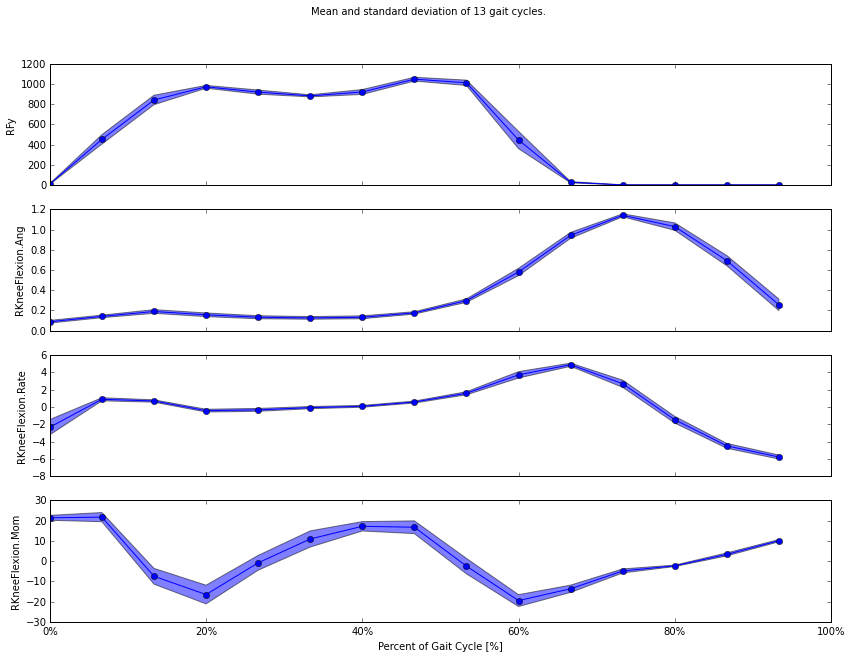

In [37]:
right_steps = data.split_at('right', num_samples=15)
axes = data.plot_gait_cycles('RFy', 'RKneeFlexion.Ang', 'RKneeFlexion.Rate', 'RKneeFlexion.Mom', marker='o')
axes = data.plot_gait_cycles('RFy', 'RKneeFlexion.Ang', 'RKneeFlexion.Rate', 'RKneeFlexion.Mom', mean=True)

# Identify Right Side Controller For Data Set #2

In [38]:
sensors = ['RKneeFlexion.Ang',
           'RKneeFlexion.Rate',
           'RHipFlexion.Ang',
           'RHipFlexion.Rate']

controls = ['RKneeFlexion.Mom',
            'RHipFlexion.Mom']

solver = controlid.SimpleControlSolver(right_steps, sensors, controls)

In [39]:
gains, controls, variance, gain_var, control_var, estimated_controls = solver.solve()

In [40]:
variance

array([ 8.97262812])

It is interesting to note that the gains here are of a very different scale than the previous data.

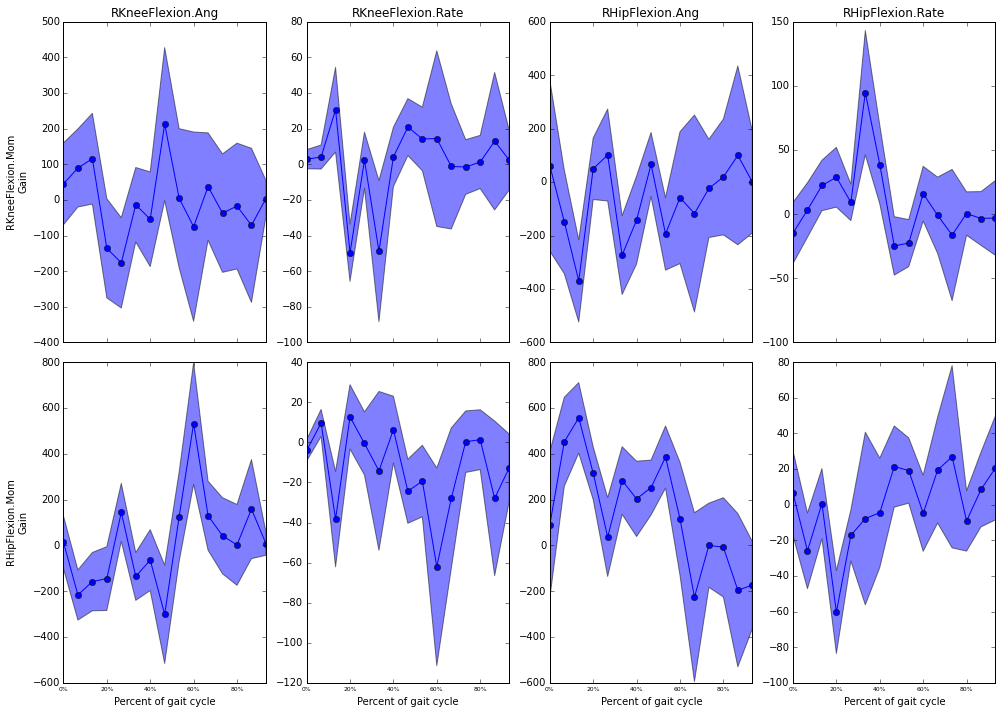

In [41]:
rcParams['figure.figsize'] = 14, 10
axes = solver.plot_gains(gains, gain_var)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7c7c805850>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f7c845bf3d0>], dtype=object)

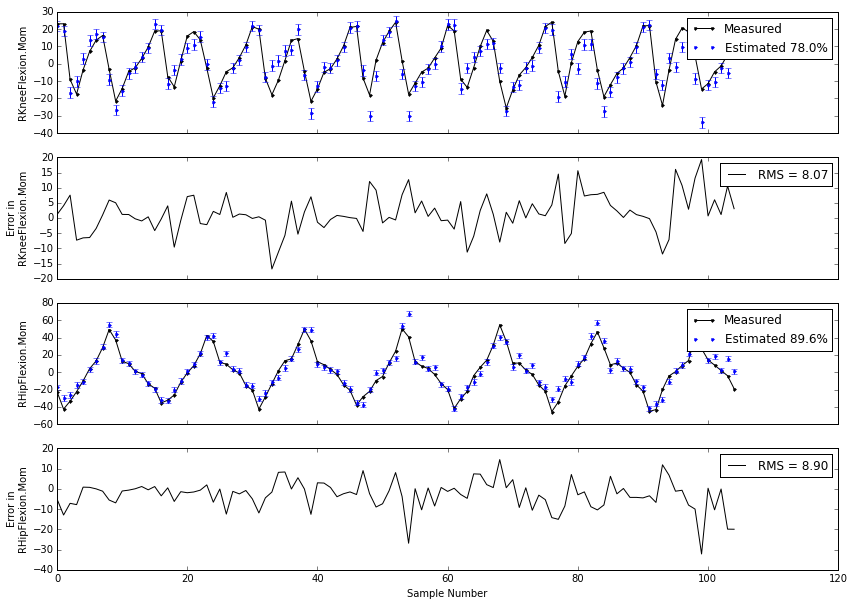

In [42]:
solver.plot_estimated_vs_measure_controls(estimated_controls, variance)

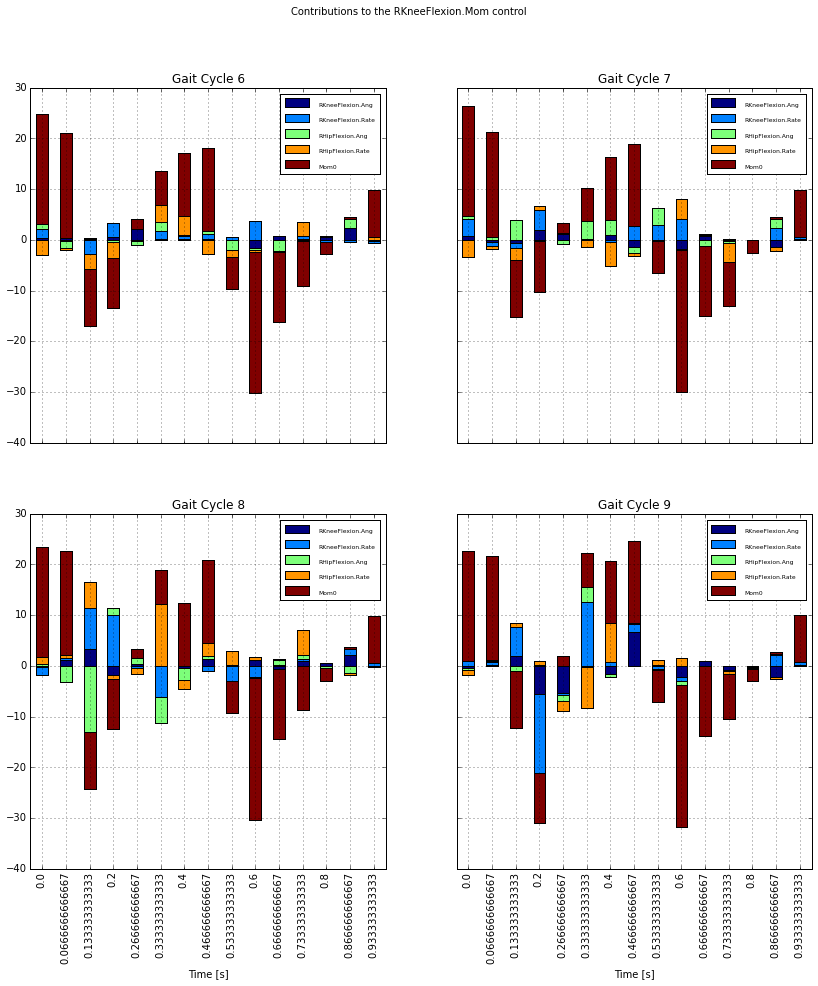

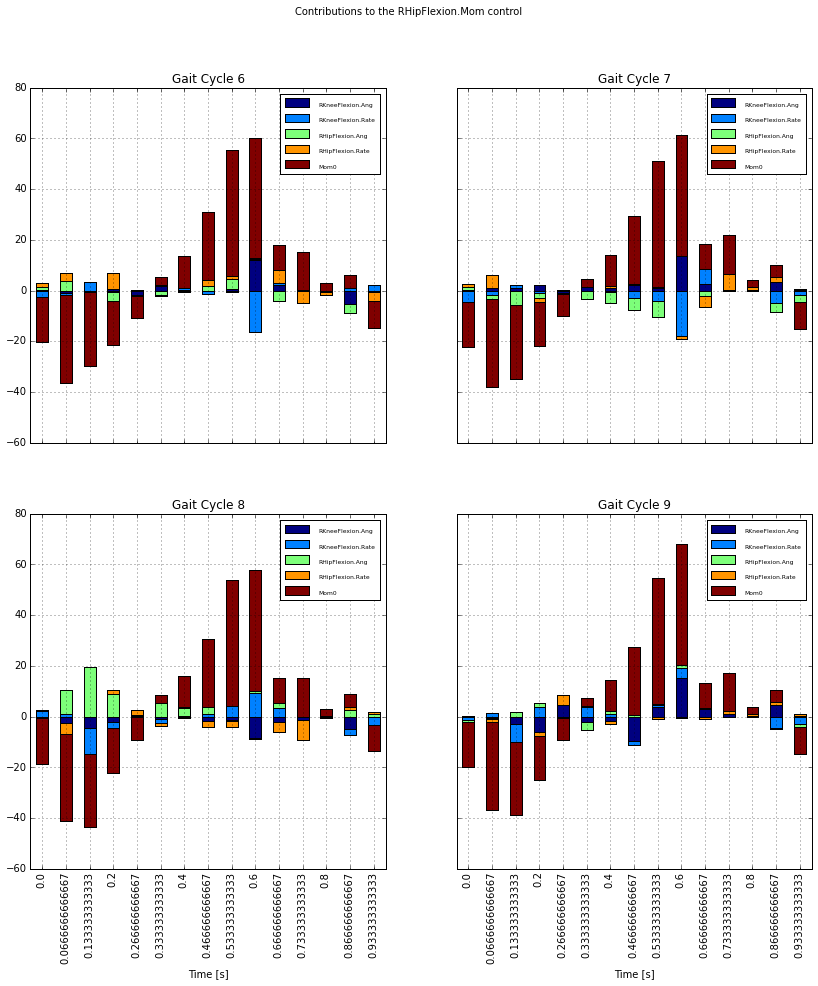

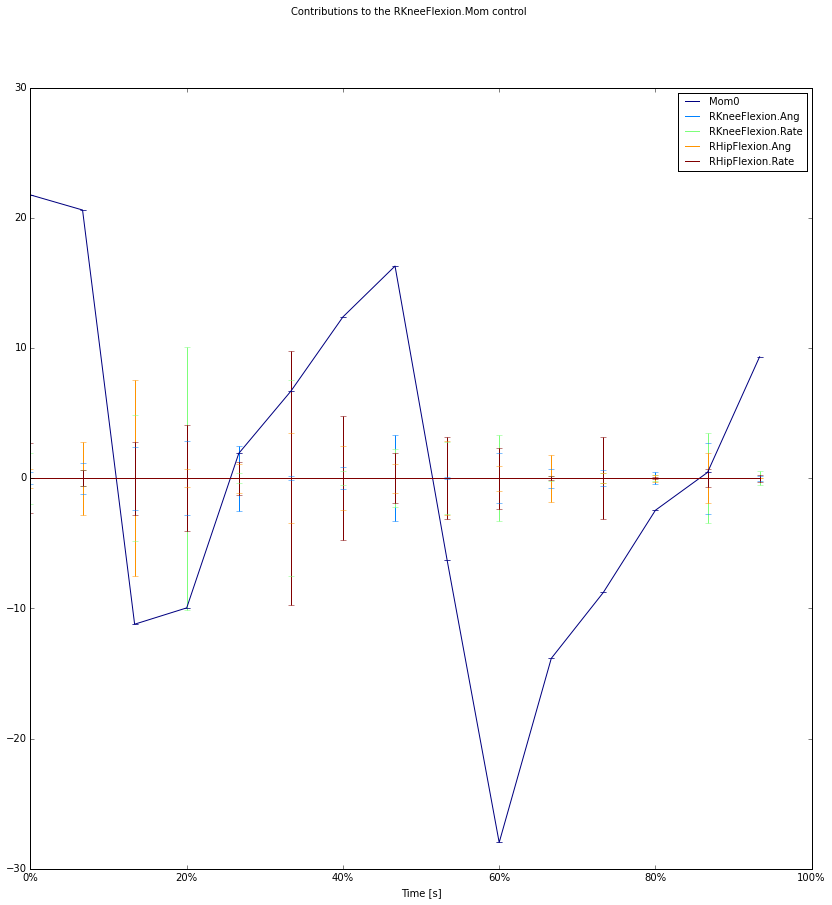

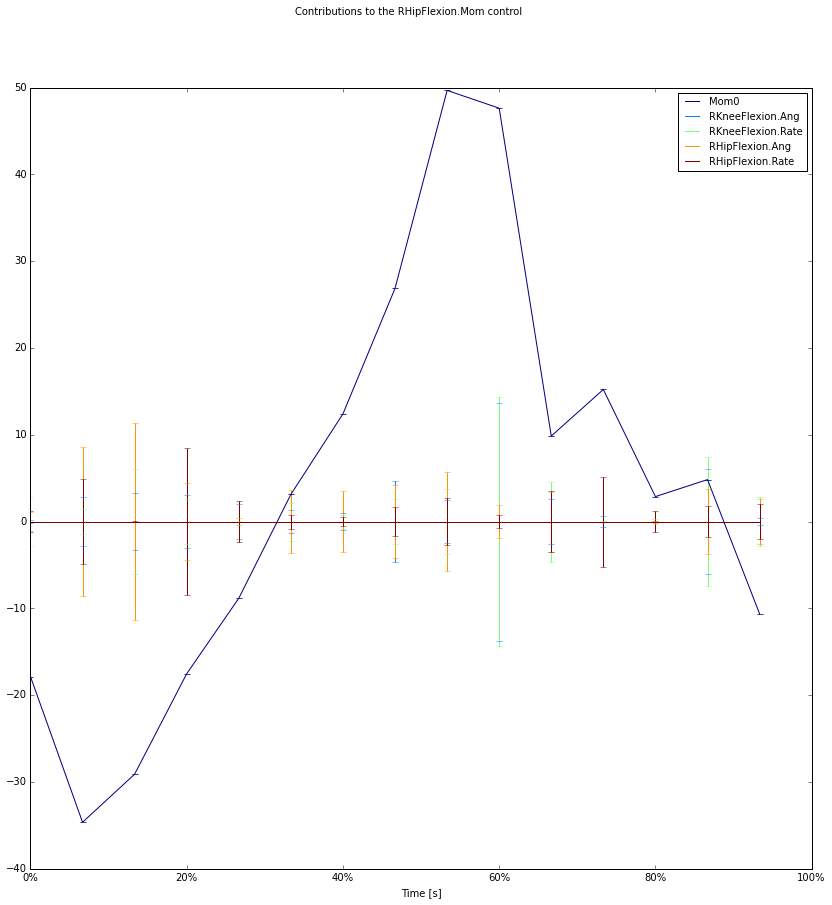

In [43]:
rcParams['figure.figsize'] = 14, 14
solver.plot_control_contributions(estimated_controls)

# Footer

In [44]:
!git rev-parse HEAD

6af0c229bb0a9edf78f8489d5f0efe02d5685a57


In [45]:
!git --git-dir=/home/moorepants/src/GaitAnalysisToolKit/.git --work-tree=/home/moorepants/src/GaitAnalysisToolKit rev-parse HEAD

9e80dfdcfe0a14b44e0ebcbadb6e9e827d215c3c


In [46]:
%install_ext http://raw.github.com/jrjohansson/version_information/master/version_information.py

Installed version_information.py. To use it, type:
  %load_ext version_information


In [47]:
%load_ext version_information

In [48]:
%version_information numpy, scipy, pandas, matplotlib, tables, oct2py, dtk, gaitanalysis

Software versions
Python 2.7.9 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython 3.0.0
OS Linux 3.13.0 49 generic x86_64 with debian jessie sid
numpy 1.9.2
scipy 0.15.1
pandas 0.16.0
matplotlib 1.4.2
tables 3.1.1
oct2py 3.1.0
dtk 0.4.0
gaitanalysis 0.2.0dev
Fri Apr 24 10:38:48 2015 PDT

In [49]:
!conda list

# packages in environment at /home/moorepants/anaconda/envs/gait-direct-id-paper:
#
backports.ssl-match-hostname 3.4.0.2                   <pip>
cairo                     1.12.18                       0  
dateutil                  2.4.1                    py27_0  
dynamicisttoolkit         0.4.0                    py27_0  
fastcache                 1.0.2                    py27_0  
fontconfig                2.11.1                        2  
freetype                  2.4.10                        0  
gaitanalysistoolkit (/home/moorepants/src/GaitAnalysisToolKit) 0.2.0.dev0                <pip>
hdf5                      1.8.14                        0  
ipython                   3.0.0                    py27_0  
ipython-notebook          3.0.0                    py27_1  
jinja2                    2.7.3                    py27_1  
jsonschema                2.4.0                    py27_0  
libpng                    1.5.13                        1  
libsodium                 0.4.5         

In [50]:
!pip freeze

backports.ssl-match-hostname==3.4.0.2
DynamicistToolKit==0.4.0
fastcache==1.0.2
-e git+git@github.com:csu-hmc/GaitAnalysisToolKit.git@9e80dfdcfe0a14b44e0ebcbadb6e9e827d215c3c#egg=GaitAnalysisToolKit-origin_speedup-inverse-dynamics
ipython==3.0.0
Jinja2==2.7.3
jsonschema==2.4.0
MarkupSafe==0.23
matplotlib==1.4.2
mistune==0.5.1
nose==1.3.4
numexpr==2.3.1
numpy==1.9.2
oct2py==3.1.0
pandas==0.16.0
ptyprocess==0.4
Pygments==2.0.2
pyparsing==2.0.1
PySide==1.2.1
python-dateutil==2.4.2
pytz==2015.2
PyYAML==3.11
pyzmq==14.5.0
scipy==0.15.1
seaborn==0.5.1
six==1.9.0
snakeviz==0.3.1
sympy==0.7.6
tables==3.1.1
terminado==0.5
tornado==4.1
